### Grading Feedback

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [2]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [5]:
# Your code here
spam_df = spark.read.csv(get_training_filename('sms_spam.csv'), header=True, inferSchema=True)

### Grading Feedback

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [231]:
# your code here
spam_df1 = spam_df.select(fn.when(col('type')=='spam',1).otherwise(0).alias('spam'),'text')
print(spam_df1.toPandas().head())         ## Printing the head of spam_df1
print("Shape of spam_df1 is: ",(spam_df1.count(), len(spam_df1.columns)))        ##Printing the shape of the spam_df1

   spam                                               text
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...
3     0  U dun say so early hor... U c already then say...
4     0  Nah I don't think he goes to usf, he lives aro...
Shape of spam_df1 is:  (5574, 2)


In [7]:
print(spam_df1.limit(5).show())

+----+--------------------+
|spam|                text|
+----+--------------------+
|   0|Go until jurong p...|
|   0|Ok lar... Joking ...|
|   1|Free entry in 2 a...|
|   0|U dun say so earl...|
|   0|Nah I don't think...|
+----+--------------------+

None


# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [230]:
# your code here
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered_text")

sw_remove_pipeline = Pipeline(stages=[tokenizer,sw_filter]).fit(spam_df1)

spam_df2 = sw_remove_pipeline.transform(spam_df1).select('spam','text','filtered_text')

print(spam_df2.toPandas().head())         ## Printing the head of spam_df2
print("Shape of spam_df2 is: ",(spam_df2.count(), len(spam_df2.columns)))        ##Printing the shape of the spam_df2


   spam                                               text  \
0     0  Go until jurong point, crazy.. Available only ...   
1     0                      Ok lar... Joking wif u oni...   
2     1  Free entry in 2 a wkly comp to win FA Cup fina...   
3     0  U dun say so early hor... U c already then say...   
4     0  Nah I don't think he goes to usf, he lives aro...   

                                       filtered_text  
0  [jurong, point, crazy, available, bugis, n, gr...  
1                     [ok, lar, joking, wif, u, oni]  
2  [free, entry, wkly, comp, win, fa, cup, final,...  
3               [u, dun, say, early, hor, u, c, say]  
4             [nah, don, t, think, goes, usf, lives]  
Shape of spam_df2 is:  (5574, 3)


In [9]:
print(spam_df2.limit(5).show())

+----+--------------------+--------------------+
|spam|                text|       filtered_text|
+----+--------------------+--------------------+
|   0|Go until jurong p...|[jurong, point, c...|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|
|   1|Free entry in 2 a...|[free, entry, wkl...|
|   0|U dun say so earl...|[u, dun, say, ear...|
|   0|Nah I don't think...|[nah, don, t, thi...|
+----+--------------------+--------------------+

None


### Grading Feedback

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [33]:
# Your code here

from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer()\
  .setInputCol("filtered_text")\
  .setOutputCol("tf")

from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

tfidf_pipeline = Pipeline(stages=[cv,idf]).fit(spam_df2)
spam_df3 = tfidf_pipeline.transform(spam_df2).select('spam','text','filtered_text','tfidf')
print(spam_df3.toPandas().head())        ## Printing the head of spam_df3
print("Shape of spam_df3 is: ",(spam_df3.count(), len(spam_df3.columns)))        ##Printing the shape of the spam_df3
tfidf_score = list(tfidf_pipeline.stages[1].idf)
vocab = list(tfidf_pipeline.stages[0].vocabulary)
for i in (sorted(range(len(tfidf_score)), key=lambda i: tfidf_score[i])[-10:]):
    print("One of the 10 most important words: ",vocab[i])
for i in (sorted(range(len(tfidf_score)), key=lambda i: tfidf_score[i])[0:10]):
    print("One of the 10 least important words: ",vocab[i])
print("Number of columns in TFIDF data: ",len(tfidf_pipeline.stages[1].idf))
print("Number of rows in TFIDF data: ",spam_df3.count())

   spam                                               text  \
0     0  Go until jurong point, crazy.. Available only ...   
1     0                      Ok lar... Joking wif u oni...   
2     1  Free entry in 2 a wkly comp to win FA Cup fina...   
3     0  U dun say so early hor... U c already then say...   
4     0  Nah I don't think he goes to usf, he lives aro...   

                                       filtered_text  \
0  [jurong, point, crazy, available, bugis, n, gr...   
1                     [ok, lar, joking, wif, u, oni]   
2  [free, entry, wkly, comp, win, fa, cup, final,...   
3               [u, dun, say, early, hor, u, c, say]   
4             [nah, don, t, think, goes, usf, lives]   

                                               tfidf  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  (1.8914559363553713, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  (0.0, 4.732932264526793, 2.6026000033672867, 0...  
3  (3.7829118727107427, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  (0.0, 0.0, 2

Your model overfit explanation here: Based on the number of rows and columns, we can surely expect the model to overfit as the number of columns are more than the number of rows and excessive number of features will result in overfitting which can be reduced by performing elastic net regularization.

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [24]:
# your code here
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().\
    setLabelCol('spam').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

pipe1 = Pipeline(stages=[lr])
logisticregression_df = pipe1.fit(spam_df3).transform(spam_df3)
logisticregression_df.show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|spam|                text|       filtered_text|               tfidf|       rawPrediction|         probability|prediction|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   0|Go until jurong p...|[jurong, point, c...|(7443,[15,26,52,6...|[46.4832509984271...|[1.0,6.4950214616...|       0.0|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|(7443,[0,8,216,32...|[37.0230287333609...|[1.0,8.3387877120...|       0.0|
|   1|Free entry in 2 a...|[free, entry, wkl...|(7443,[1,2,9,21,2...|[-25.376984268883...|[9.52611378547952...|       1.0|
|   0|U dun say so earl...|[u, dun, say, ear...|(7443,[0,50,75,13...|[43.4350408188821...|[1.0,1.3689937049...|       0.0|
|   0|Nah I don't think...|[nah, don, t, thi...|(7443,[2,30,46,33...|[37.2489681189668...|[1.0,6.6524051231...|       0.0|
+----+----------

### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [55]:
# your code here
#from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
grid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator(labelCol = 'spam',metricName = 'areaUnderROC')
cv1 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv1 = cv1.fit(spam_df3)

### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [70]:
# your code here
evaluator.evaluate(fitted_cv1.transform(spam_df3), {evaluator.metricName: "areaUnderROC"})   ### AUC on spamdf3_test

1.0

### Grading Feedback

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

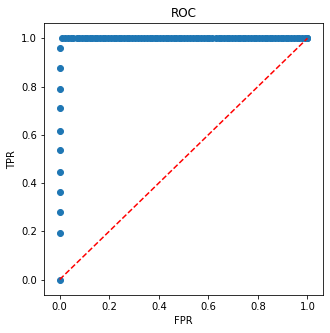

In [232]:
# your code here
import matplotlib.pyplot as plt
fitted_pipe1 = lr.fit(spam_df3)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.scatter(fitted_pipe1.summary.roc.select('FPR').collect(),
         fitted_pipe1.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
display()

### Grading Feedback

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [58]:
# your code here
#from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0.005, 0.01, 0.02,0.03]).\
    addGrid(lr.elasticNetParam, [0.05, 0.1, 0.2,0.3]).\
    build()
evaluator = BinaryClassificationEvaluator(labelCol = 'spam',metricName = 'areaUnderROC')
cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv2 = cv2.fit(spam_df3)

In [84]:
### Counting number of features with non zero coefficients
np.count_nonzero(fitted_cv2.bestModel.stages[0].coefficients.toArray())

1242

### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [186]:
# your code here
print("AUC from fitted_cv2: ",evaluator.evaluate(fitted_cv2.bestModel.transform(spam_df3), {evaluator.metricName: "areaUnderROC"}))
print("The lambda value of L1 L2 regularization: ",fitted_cv2.bestModel.stages[0]._java_obj.getRegParam())
print("The alpha value of L1 L2 regularization: ",fitted_cv2.bestModel.stages[0]._java_obj.getElasticNetParam())
print("The total number of features are: ",len(fitted_cv2.bestModel.stages[0].coefficients.toArray()))
print("Number of features that L1 eliminated: ", len((fitted_cv2.bestModel.stages[0].coefficients.toArray()))-np.count_nonzero(fitted_cv2.bestModel.stages[0].coefficients.toArray()))
coeffs = fitted_cv2.bestModel.stages[0].coefficients.toArray()
dict_words_coeffs = {}
for i in range(len(coeffs)):
    dict_words_coeffs[vocab[i]] = abs(coeffs[i])
eliminated_words = []
for i in dict_words_coeffs.items():
    if i[1] == 0:
        eliminated_words.append(i[0])
print("Sample of 10 Words that were eliminated: ",eliminated_words[0:10])

AUC from fitted_cv2:  0.9999894613326589
The lambda value of L1 L2 regularization:  0.01
The alpha value of L1 L2 regularization:  0.05
The total number of features are:  7443
Number of features that L1 eliminated:  6201
10 Words that were eliminated:  ['s', 't', 'm', 'just', 'like', 'day', 'time', 'love', 'want', 'n']


### Grading Feedback

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [214]:
# your code here
top_10_words = []
bottom_10_words = []
dict_words_coeffs_sort_desc = {k: v for k, v in sorted(dict_words_coeffs.items(), key=lambda item: item[1],reverse=True)}
dict_words_coeffs_sort_asc = {k: v for k, v in sorted(dict_words_coeffs.items(), key=lambda item: item[1])}
for i in list(dict_words_coeffs_sort_desc.items())[0:10]:
    top_10_words.append((i[0],i[1]))
print("10 WORDS THAT CONTRIBUTE THE MOST & their COEFFICIENTS: ",top_10_words)
for i in list(dict_words_coeffs_sort_asc.items()):
    if i[1] != 0:
        bottom_10_words.append((i[0],i[1]))
print("\n10 WORDS THAT CONTRIBUTE THE LEAST & their COEFFICIENTS: ",bottom_10_words[0:10])

10 WORDS THAT CONTRIBUTE THE MOST & their COEFFICIENTS:  [('teenager', 0.854823549388191), ('freephone', 0.8353846142674471), ('voicemail', 0.8171072301477244), ('ringtoneking', 0.786089309503098), ('wining', 0.756191666401203), ('tattoos', 0.7061974274138932), ('premium', 0.6926164558744172), ('tf', 0.6912715845735495), ('minmoremobsemspobox', 0.5872896878935332), ('stchoice', 0.565547086246528)]

10 WORDS THAT CONTRIBUTE THE LEAST & their COEFFICIENTS:  [('satisfied', 2.1745201889077365e-05), ('maneesha', 2.1745201889077365e-05), ('toll', 2.1745201889077365e-05), ('algarve', 3.2539738346245155e-05), ('eyes', 7.747065100211463e-05), ('solve', 9.063002627466452e-05), ('watching', 0.00013319164790986688), ('important', 0.00020379047099947615), ('long', 0.00041705389498167896), ('app', 0.0004471775791209139)]


Your comments here: These words make sense because, some of the top 10 words that contribute to predicting spam are 'minmoremobsemspobox','stchoice','tf','ringtoneking' etc. which are clearly spam words and there is no confusion or ambiguity as to whether emails containing these words are spam or not as these are words don't have any meaning and hence all these emails can be classified as SPAM with full certainity.

On the other hand, the words like 'satisfied','long','eyes','app' etc. can be very ambiguous and we cannot tell with full certainity as to whether the emails containing these words are SPAM or not. These emails are ambiguous as they may or may not be SPAM emails. Hence these words are the ones that contribute the least in predicting whether the email is a SPAM email or not.

### Grading Feedback

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [22]:
# do not delete or change this cell

# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

In [228]:
# your code here
import sympy as sp
#from sympy.interactive import printing
#printing.init_printing(use_latex = True)
from sympy.solvers import solve
from sympy import Symbol
c,g,h,e,a,b,d,f = sp.symbols('c g h e a b d f')
print(sp.latex(sp.solve((c*g) - (c*h) + (e*(a+1)**b) - ((d*(((a+1)**b)-1))/a) + ((f*(((a+1)**b)-1))/a), c)))

\left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right]


Add your latex output here such that a human readable equation is displayed for grading

$$ \left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right] $$


### Grading Feedback